# CSCA 5642 - Deep Learning Final Project


## Problem Description 

### Project Topic

The topic of this project is Reinforcement Learning but also Deep Learning as this project will use Deep Q Learning (DQN) which involves multilayer Neural Networks like we have been using throughout the CSCA5642 class. I was interested in Reinforcement Learning before taking this Course Specialization and was hoping we would go over this in one of our classes. Since we did not go over it, I am doing my final project on Reinforcement Learning and how Deep Learning can be used to tackle RL problems.

![Problem Description](images/problem_description.png)

The Machine Learning problem provided at the link below is a simple Reinforcement Learning Game. In this game there is a cart that is confined to moving in one dimension, left or right. On top of the cart there is a balanced pole and the pole will fall over if not corrected by movements of the cart. The cart may move either left or right to keep the pole balanced on top of the cart. The goal of this project is to balance the pole ontop of the cart for up to 500 steps.

### Data Description

Source for Project Data:
https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Citation:

Gym Library. (n.d.). CartPole-v1. Gymnasium. Retrieved November 23, 2024, from https://www.gymlibrary.dev/environments/classic_control/cart_pole/


Unlike all of the other projects in the CSCA Machine Learning Class Specialization, the data for this problem does not come pre-packaged for our use. Instead, we access a simulated environment using the Gym Library for python. This simulated environment for "CartPole-v1" will give us four data points for any given point in the simulation: Cart Position, Cart Velocity, Pole Angle, and Pole Angular Velocity. Instead of a pre-filled out table with many combinations of these values to train on, we must run the simulation and have our model take actions and observe how these parameters change. So this project will involve running many hundreds of simulations to produce many thousands of data points for our model to learn from.

There is no 'size' of this data. The size of the data is up to how much data the user would like to generate when training models.

| State Variable | Limits |
|---------------|---------------|
| Cart Position |  +/- 4.8 |
| Cart Velocity  | No Limits  |
| Pole Angle  | +/- .418 rad  |
| Pole Ang. Velocity  | No Limits   |

![Boundaries for data](images/boundaries.png)


## Exploratory Data Analysis

As with any Machine Learning problem, it is important to understand the data and what is available to train our models on. In addition there are data preparation steps that need to be taken in order to set up our models for success.

Our data is somewhat interesting relative to the other datasets that were used in the CSCA Machine Learning Specialization, as it is generated on the fly and not provided. For example, a correlation matrix is not possible to make for this kind of data.

In [87]:
# Lets Start by Handling all of our imports
import os
import gym
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
from matplotlib import pyplot as plt

### Data Exploration

Let's explore the dataset and see what we have to work with to model this problem.

In [37]:
# Load in the CartPole Simulation
env = gym.make("CartPole-v1")

Start by taking a look at what actions we have available for our models to take:

In [83]:
# Lets Observe the action space
print("Environment Action Space:")
print(env.action_space)

N_ACTIONS = env.action_space.n

Environment Action Space:
Discrete(2)


We can see that our action space (the actions we are trying to predict/recommend to take) are a discrete set of 2 values. So a binary classification style prediction.

In other words, the actions we can take with the cart are 0 and 1, for left and right.

Next, lets take a look at the state space or observation space:

In [84]:
# Lets look at the observation space
print("Environment Observation Space:")
print(env.observation_space)

print("")
print("Lower Bounds")
print(env.observation_space.low)
print("")
print("Upper Bounds")
print(env.observation_space.high)

N_STATES = env.observation_space.shape[0]

Environment Observation Space:
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Lower Bounds
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]

Upper Bounds
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


We can see that there are 4 observations that are provided by this simulation. These are the values that we will be inputting into our Deep Learning Model. From the table presented above, we know that they are the following:

| State Variable | Limits |
|---------------|---------------|
| Cart Position |  +/- 4.8 |
| Cart Velocity  | No Limits  |
| Pole Angle  | +/- .418 rad  |
| Pole Ang. Velocity  | No Limits   |

Ok, lets take a look at other information we can see from our environment:

In [34]:
print(env.spec)
print("Reward Threshold: {}".format(env.spec.reward_threshold))
print("Max Episode Steps: {}".format(env.spec.max_episode_steps))

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)
Reward Threshold: 475.0
Max Episode Steps: 500


We can see that the reward threshold is listed as 475. This can be thought of as the 'Win' condition of the game or as a goal to get your model consistently acheiveing scores of 475 or higher. Also listed is the maximum steps allowed per episode. This means that if our model survives 500 steps, then the game ends and no more score can be awarded. This helps limit the training time and prevents a model from continuing to run for very long periods of time.

Alright, now lets take a look at what it actually looks like to run the simulation:

Showing .reset() functionality
(array([ 0.03422656, -0.04922483, -0.00312502, -0.02253869], dtype=float32), {})

Run 1000 Resets:
[ 0.03682291 -0.0379139  -0.01341129  0.03452696]
[-0.0026251   0.02090359  0.00328423  0.0298802 ]
[ 0.02718181 -0.0430167  -0.04250601 -0.00707791]
[ 0.01200782  0.04319487  0.00788486 -0.01860432]
[-0.02481089 -0.03848322 -0.04221282 -0.00970288]
[-0.02826937 -0.00742963 -0.03903954 -0.02674553]
[ 0.02905713 -0.0019492  -0.03741729 -0.01029172]
[ 0.00392913  0.0046998  -0.03094429  0.01256961]
[-0.00718927 -0.03523953  0.04011638 -0.0112015 ]
[0.03731079 0.03925716 0.01985192 0.0018572 ]



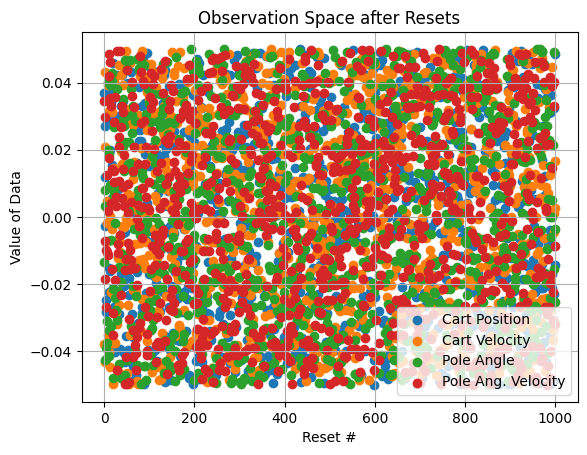

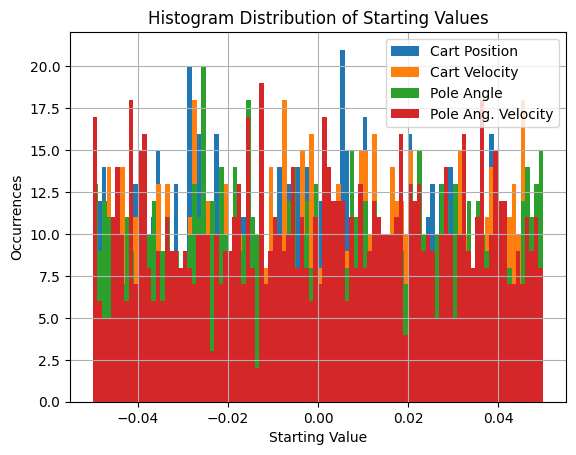

In [86]:
# First show the Reset Functionality
print("Showing .reset() functionality")
state = env.reset()
print(state)
print("")
resets = 1000
print(f"Run {resets} Resets:")
xs = []
c_pos = []
c_vels = []
p_angs = []
a_vels = []
for i in range(resets):
    state = env.reset()[0]
    if i < 10:
       print(state)
    c_pos.append(state[0])
    c_vels.append(state[1])
    p_angs.append(state[2])
    a_vels.append(state[3])
    xs.append(i)
print("")

plt.scatter(xs, c_pos)
plt.scatter(xs, c_vels)
plt.scatter(xs, p_angs)
plt.scatter(xs, a_vels)

plt.grid()
plt.title("Observation Space after Resets")
plt.xlabel("Reset #")
plt.ylabel("Value of Data")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
])
plt.show()

n_bins = 100
plt.hist(c_pos, bins=n_bins)
# plt.show()
plt.hist(c_vels, bins=n_bins)
# plt.show()
plt.hist(p_angs, bins=n_bins)
# plt.show()
plt.hist(a_vels, bins=n_bins)
plt.grid()
plt.title("Histogram Distribution of Starting Values")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
])
plt.ylabel("Occurrences")
plt.xlabel("Starting Value")
plt.show()


Ok, we can see that calling the .reset() function will start the game over and set the state to when the cart is near the center of the arena and the pole is upright with a minor speed value. 
We can see that after running many resets, there is always a minor random value that is set to each of the items in the observation space. There seems to be a uniform distribution of randomized values for each parameter in the range -.05 to +.05

This helps to avoid overfitting of our model as the starting conditions will always be slightly different.

Showing .step() functionality
(array([-0.80367565, -3.9375675 ,  1.3321071 ,  7.209693  ], dtype=float32), 0.0, True, False, {})

Run 20 Steps with the same action:


c:\Users\Ben\Workspace\CSCA5642Final\venv\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


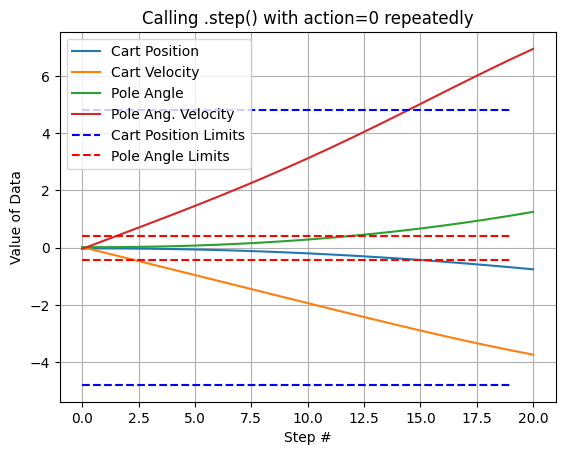

In [ ]:
# Show the step functionality
print("Showing .step() functionality")
response = env.step(0)
print(response)
print("")
steps = 20

print(f"Run {steps} Steps with the same action:")
state = env.reset()
xs = [0]
c_pos = [state[0][0]]
c_vels = [state[0][1]]
p_angs = [state[0][2]]
a_vels = [state[0][3]]
for i in range(steps):
    ans = env.step(0)
    state = ans[0]
    c_pos.append(state[0])
    c_vels.append(state[1])
    p_angs.append(state[2])
    a_vels.append(state[3])
    xs.append(i+1)

c_limit_low_xs = [0, steps-1]
c_limit_low_ys = [-4.8, -4.8]

c_limit_high_xs = [0, steps-1]
c_limit_high_ys = [4.8, 4.8]

pa_limit_low_xs = [0, steps-1]
pa_limit_low_ys = [-.418, -.418]

pa_limit_high_xs = [0, steps-1]
pa_limit_high_ys = [.418, .418]

plt.plot(xs, c_pos)
plt.plot(xs, c_vels)
plt.plot(xs, p_angs)
plt.plot(xs, a_vels)

plt.plot(c_limit_low_xs,c_limit_low_ys, 'b--')
plt.plot(pa_limit_low_xs,pa_limit_low_ys, 'r--')

plt.plot(c_limit_high_xs,c_limit_high_ys, 'b--')
plt.plot(pa_limit_high_xs,pa_limit_high_ys, 'r--')

plt.grid()
plt.title("Calling .step() with action=0 repeatedly")
plt.xlabel("Step #")
plt.ylabel("Value of Data")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
    "Cart Position Limits",
    "Pole Angle Limits"
])
plt.show()

Calling the .step() function repeatedly with the same action gives us insight on how our data is formatted and also how quickly incorrect actions can lead to a failure in the game. The failure in the graph occurs roughly at step 12, when thew Pole Angle crosses the allowed value.

Also it can be noticed that these values do not seem to be similarly scaled. This could be a problem when training our model, so its important to perform some Data Cleaning. Unlike other ML problems, the data is not cleaned at the beginning, and we will need to clean our data on the fly.

### Data Cleaning

To start with cleaning, we can and should normalize our data so everything is in a comparable range. This will help to prevent overfitting, and allow parameters with less extreme values to still hold high importance in the 'mind' of our model.

Its easy to pick the normalization values for the bounded values (the cart position and the pole angle). We simply just scale those values so that all values are between -1 and 1 where the bounds are -1 and 1.

The continuous values of cart speed and pole angular speed are different however. We must pick a value that will become 1 and -1. Based on the 'Runaway' experiment performed above, it looks like both speeds really should not exceed -5 and +5 in normal operation. So we will scale everything for those variables to also be between -1 and 1 where -1 correlates with a speed of -5 and 1 correlates with a speed for both cart speed and pole angular speed.

In [58]:
def normalize_cart_position(cpos):
    """
    Normalize the position of the cart to be between -1 and 1
    """
    return round(cpos/4.8,3)

def normalize_cart_speed(cspeed):
    """
    Normalize the speed of the cart to be betweeen -1 and 1
    """
    return round(cspeed/5, 3)

def normalize_pole_angle(pang):
    """
    Normalize the pole angle of the cart to be betweeen -1 and 1
    """
    return round(pang/.418, 3)

def normalize_pole_angular_velocity(pvel):
    """
    Normalize the pole angle of the cart to be betweeen -1 and 1
    """
    return round(pvel/5, 3)

Actually, the above methods are kind of slow and clunky to apply during training, lets build a single method that uses numpy for speed and has it all in one line.


In [61]:
def normalize_data(state):
    """
    A Faster way to normalize the data
    """    
    normalization_factors = np.array([4.8, 5, .418, 5])
    return state/normalization_factors

Lets test the normalization and show that it scales our data much more reasonably:

Run 20 Steps with the same action:


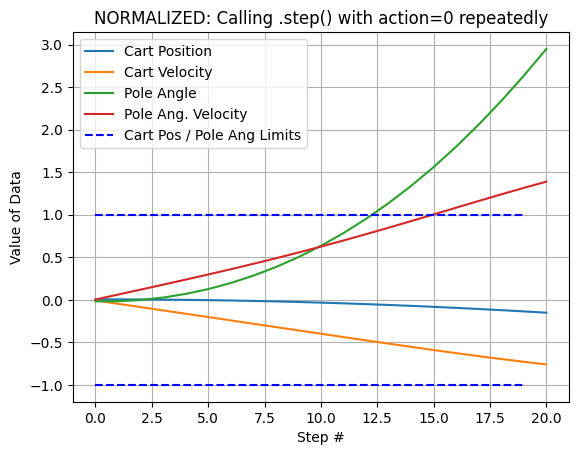

In [70]:
print(f"Run {steps} Steps with the same action:")
state = env.reset()[0]
state = normalize_data(state)
xs = [0]
c_pos = [state[0]]
c_vels = [state[1]]
p_angs = [state[2]]
a_vels = [state[3]]
for i in range(steps):
    ans = env.step(0)
    state = ans[0]
    state = normalize_data(state)
    c_pos.append(state[0])
    c_vels.append(state[1])
    p_angs.append(state[2])
    a_vels.append(state[3])
    xs.append(i+1)

c_limit_low_xs = [0, steps-1]
c_limit_low_ys = [-1, -1]

c_limit_high_xs = [0, steps-1]
c_limit_high_ys = [1, 1]

plt.plot(xs, c_pos)
plt.plot(xs, c_vels)
plt.plot(xs, p_angs)
plt.plot(xs, a_vels)

plt.plot(c_limit_low_xs,c_limit_low_ys, 'b--')
plt.plot(c_limit_high_xs,c_limit_high_ys, 'b--')

plt.grid()
plt.title("NORMALIZED: Calling .step() with action=0 repeatedly")
plt.xlabel("Step #")
plt.ylabel("Value of Data")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
    "Cart Pos / Pole Ang Limits",
])
plt.show()

Nice, the data looks to be much nicer scaled relative to each other than before normalization. This concludes all of the data cleaning that needs to happen for this project. Since this is a simulation, we do not need to worry about any missing values or problematic values as the simulation will only return valid numbers.

If it is noticed that the speeds exceed -1 or +1 at some point during training these values for normalization for the speeds may need to be adjusted.

## Model Building

Before we can begin training, it makes sense to set up a class to contain all of our variables, hyperparameters, methods, etc. This will be used by all experiments in this project.

In [ ]:
class CartPoleTrainer():
    """
    Class to contain CartPole Methods neccessary to train cartpole
    """

    def __init__(self, model = None):
        """
        Set up the class
        """
        self.env = gym.make("CartPole-v1", render_mode = 'rgb_array')
        self._define_constants()

        self.model = model

    def _define_constants(self):
        """
        Define Constants, variables
        """
        RANDOM_SEED = 23
        np.random.seed(RANDOM_SEED)
        random.seed(RANDOM_SEED)

        self.N_EPISODES = 1000
        self.MIN_EPSILON = .001
        self.EPSILON_DECAY_RATE = .999
        self.epsilon = 1

        self.BATCH_SIZE = 128
        self.GAMMA = .99

        # Memory
        self.memory = []
        self.MAX_MEMORY_SIZE = 2000
        self.MIN_MEMORY_SIZE = 1000

        self.EVALUATION_BATCH = 20

        # Debugging stuff
        currdir = os.path.dirname(__file__)
        self.results_table = []
        self.csv_dump = currdir + "\\test.csv"

    def preliminary_epsilon_plot(self):
        xs = [i for i in range(self.N_EPISODES*100)]
        ys = []
        ep = self.epsilon
        for x in xs:
            ep = ep * self.EPSILON_DECAY_RATE
            ys.append(ep)
        plt.plot(xs, ys)
        plt.xlabel("# of Traning Batches")
        plt.ylabel("Epsilon (Explore Rate)")
        plt.title("Epsilon Decay over planned episodes")
        plt.grid()
        plt.pause(1)
        plt.cla()

    def append_to_results_table(self, episode, reward, epsilon):
        d = {}
        d["episode"] = episode 
        d["reward"] = int(reward)
        d["epsilon"] = epsilon
        self.results_table.append(d)

        df = pd.DataFrame(self.results_table)
        df.to_csv(self.csv_dump)
        
    def perform_action(self, state):
        """
        go ahead and take action, this requires a model first to use
        """
        if np.random.rand() <= self.epsilon:
            # Exploring
            return self.env.action_space.sample()
        else:
            # Going with Model's best guess so far
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def decay_epsilon(self):
        """
        Decay the Epsilon Value
        """
        self.epsilon = round(max(self.epsilon * self.EPSILON_DECAY_RATE, self.MIN_EPSILON),4)
    
    def store_to_memory(self, state, action, reward, next_state, stop_condition):
        """
        Store experiences into memory for recall and use in batch training later
        """
        
        self.memory.append((
            state,
            action,
            reward,
            next_state,
            stop_condition,
        ))

        # Keep the memory under the maximum size
        if len(self.memory) > self.MAX_MEMORY_SIZE:
            self.memory.pop(0)
        
    def learn_by_batch(self):
        """
        Pull experiences from the memory and apply learning
        """
        if len(self.memory) < self.BATCH_SIZE:
            # There are not enough datas to learn from yet
            print("There are not yet enough samples to learn from")
            return
        
        # print("Initiating Batch Learning")
        batch = random.sample(self.memory, self.BATCH_SIZE)

        states = np.zeros((self.BATCH_SIZE, self.n_states))
        next_states = np.zeros((self.BATCH_SIZE, self.n_states))
        
        actions = []
        rewards = []
        stop_conditions = []

        for iter, memory_slice in enumerate(batch):
            states[iter] = memory_slice[0][0]
            actions.append(memory_slice[1])
            rewards.append(memory_slice[2])
            next_states[iter] = memory_slice[3][0]
            stop_conditions.append(memory_slice[4])

        q_values = self.model.predict(states, verbose=0)
        q_values_next = self.model.predict(next_states, verbose = 0)
    
        for i in range(len(states)):
            if stop_conditions[i] == True:
                q_values[i][actions[i]] = rewards[i]

            else:
                # Bellman equation
                q_values[i][actions[i]] = rewards[i] + self.GAMMA * (np.amax(q_values_next[i]))

        # Fit the model given the new desired outcome
        self.model.fit(states, q_values, verbose = 0)

    def test_loop(self):
        print("starting test loop")

    def perform_step(self, action):
        """
        Placing this method here to maximize code re-use
        Just parses the step response
        """
        ans = self.env.step(action)
        next_state = np.reshape(ans[0], [1, self.n_states])
        reward = ans[1]
        stop_condition = ans[2]
        return next_state, reward, stop_condition

    def main_loop(self):
        rewards = []
        episodes = []

        print("========================================")
        print("Performing Initial Memory Population")
        while len(self.memory) < self.MIN_MEMORY_SIZE:
            state = self.env.reset()
            state = np.reshape(state[0], [1,self.n_states])
            stop_condition = False

            while stop_condition is not True:
                action = self.env.action_space.sample()
                next_state, reward, stop_condition = self.perform_step(action)
                self.store_to_memory(state, action, reward, next_state, stop_condition)
        print("Finished Initial Memory Population")
        print("========================================")
        print("")

        print("========================================")
        print("Beginning Training Loop")
        best_reward = 0
        for episode in range(self.N_EPISODES):
            state = self.env.reset()
            state = np.reshape(state[0], [1,self.n_states])

            total_reward = 0

            stop_condition = False
            while stop_condition is not True:
                action = self.perform_action(state)
                next_state, reward, stop_condition = self.perform_step(action)
                self.store_to_memory(state, action, reward, next_state, stop_condition)

                state = next_state
                total_reward += reward

                self.learn_by_batch()
                self.decay_epsilon()

            self.append_to_results_table(episode, total_reward, self.epsilon)

            print("Episode {}, Reward: {}, Epsilon: {}".format(episode, int(total_reward), self.epsilon))

        print("========================================")
        print("")

### Build MVP

Lets kick off our project by building a minimum viable product and see how it performs

In [85]:
LEARNING_RATE = .0001

model_mvp = Sequential()
model_mvp.add(Dense(16, input_dim = N_STATES, activation = 'relu'))
model_mvp.add(Dense(8, activation = 'relu'))
model_mvp.add(Dense(N_ACTIONS, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_mvp.compile(
    loss='mse',
    optimizer = optimizer)

model_mvp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                80        
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 2)                 18        
                                                                 
Total params: 234
Trainable params: 234
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_states = 4
n_actions = 2
LEARNING_RATE = .0001

model_final = Sequential()
model_final.add(Dense(512, input_dim = n_states, activation = 'relu'))
model_final.add(Dense(256, activation = 'relu'))
model_final.add(Dense(128, activation = 'relu'))
model_final.add(Dense(n_actions, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_final.compile(
    loss='mse',
    optimizer = optimizer)

##